## **AdaIN을 이용한 Style Transfer**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import libraries

import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image

In [ ]:
# AdaIN Style Transfer network
# 결과 내는 데는 활용하지 않지만 공부용으로 작성

class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4]) # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11]) # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18]) # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31]) # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image(중간 결과도도 기록)
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image(최종 결과만 기록)
    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    # 콘텐츠 손실(feature 값 자체가 유사해지도록)
    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    # 스타일 손실(feature의 statistics가 유사해지도록)
    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        # 콘텐츠와 스타일 중 어떤 것에 더 많은 가중치를 둘지 설정 가능
        assert 0 <= alpha <= 1 # 0에 가까울수록 콘텐츠 반영 비율 증가
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adain(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t) # 결과 이미지(ground truth)
        g_t_feats = self.encode_with_intermediate(g_t)

        # 콘텐츠 손실과 스타일 손실을 모두 줄이는 것이 목표이므로 두 개의 loss값 반환
        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

##### 이 아래부터 실질적인 결과물 산출에 활용되는 코드

In [ ]:
# Instance Normalization을 위한 평균과 표준편차 계산

def calc_mean_std(feat, eps=1e-5): # eps: 입실론. 분모에 0이 들어가는 것을 방지하기 위한 매우 작은 상수
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1) # 각 이미지의 모든 채널에 대해 표준편차 계산
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1) # 각 이미지의 모든 채널에 대해 평균 계산
    return feat_mean, feat_std

In [ ]:
# Adaptive Instance Normalization

def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    # 평균(mean)과 표준편차(std)를 이용해 normalization 수행
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    
    # 정규화 이후에 style feature의 statistics를 가지도록 설정
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

#### **인코더(Encoder)**

* VGG 네트워크에서 max pooling  4번 진행
* Style Transfer에서는 ReLU4_1까지 사용

In [ ]:
# 인코더(Encoder)

vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

#### **디코더(Decoder)**

* 디코더는 인코더의 반대격

In [ ]:
# 디코더(Decoder) 정의
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

#### **Pre-trained model 불러오기**

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2023-03-25 14:08:07--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1 [following]
--2023-03-25 14:08:08--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 14023458 (13M) [application/octet-stream]
Saving to: ‘decoder.pth’

decoder.pth         100%[===================>]  13.37M  11.4MB/s    in 1.2s    



In [ ]:
decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31]) # ReLU4_1까지만 사용

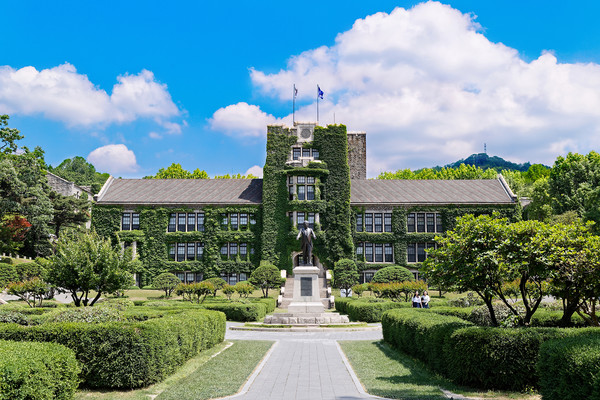

In [ ]:
# 콘텐츠(content) 이미지 출력
display_image('/content/drive/MyDrive/DSL/75049_274114_1823.jpg')

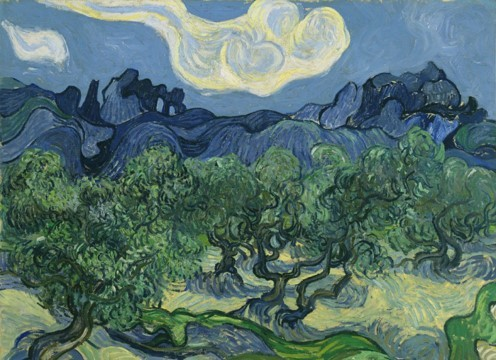

In [ ]:
# 스타일(style) 이미지 출력
display_image('/content/drive/MyDrive/DSL/01_02_고흐_올리브나무.jpg')

#### **Style Transfer 함수 구현**

In [ ]:
def style_transfer(vgg, decoder, content, style, alpha=1.0):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

#### 이미지 전처리 함수 구현

In [ ]:
def test_transform(size=512):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

content_tf = test_transform()
style_tf = test_transform()

In [ ]:
content_path = '/content/drive/MyDrive/DSL/75049_274114_1823.jpg'
style_path = '/content/drive/MyDrive/DSL/01_02_고흐_올리브나무.jpg'

content = content_tf(Image.open(str(content_path)))
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0) # alpha: 콘텐츠 비율을 조정하는 파라미터(alpha 0에 가까울수록 콘텐츠 반영 비율 증가)
output = output.cpu()

save_image(output, 'output.png')

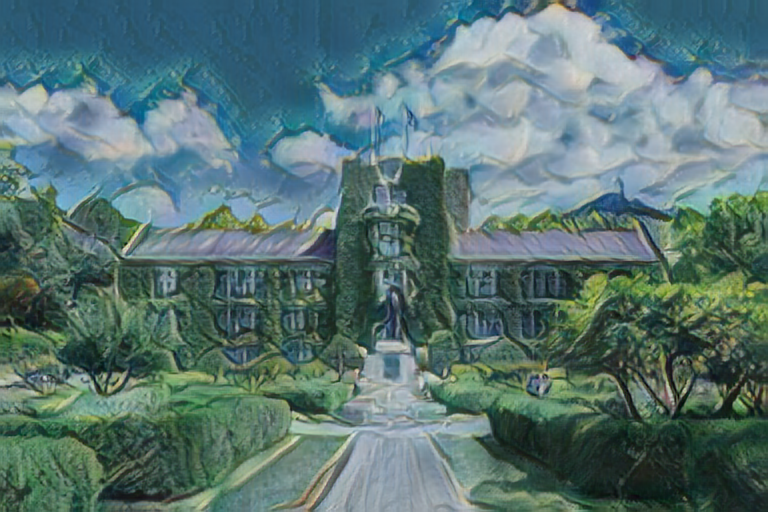

In [ ]:
# 결과 이미지 출력
display_image('./output.png')